In [1]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.9 MB 7.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd

In [5]:
train_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv')
valid_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/valid_combined.csv', index_col=0)

In [6]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [10]:
train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
def function(x):
  total = x.toxic + x.severe_toxic + x.obscene + x.threat + x.insult + x.identity_hate
  if total == 0:
    return 0
  else:
    return 1

train_data['binary'] = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].apply(function, axis=1)

In [12]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,binary
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [13]:
train_data.binary.value_counts()

0    143346
1     16225
Name: binary, dtype: int64

In [14]:
# downsampling

# class count
majority, minority = train_data.binary.value_counts()

In [15]:
# divide by class
train_data_majority = train_data[train_data['binary'] == 0]
train_data_minority = train_data[train_data['binary'] == 1]

In [16]:
#scale down the majority

train_data_majority_down = train_data_majority.sample(minority, replace=True)

In [17]:
# concat to form a new/final dataframe

train_data_final = pd.concat([train_data_majority_down, train_data_minority], axis=0)

In [18]:
train_data_final.binary.value_counts()

1    16225
0    16225
Name: binary, dtype: int64

In [7]:
valid_data

,id,comment_text
0,0,This article sucks \n\nwoo woo wooooooo
1,1,"""And yes, people should recognize that but the..."
2,2,"Western Media?\n\nYup, because every crime in..."
3,3,And you removed it! You numbskull! I don't car...
4,4,smelly vagina \n\nBluerasberry why don't you ...
...,...,...
60211,60211,get out my large penis
60212,60212,get out my large penis
60213,60213,Piss off you slant eyed-gook
60214,60214,Piss off you slant eyed-gook


In [19]:
import re

In [20]:
# data cleaning

def text_clean(x):

    x = x.lower()                               # lowercase everything
    x = x.encode('ascii', 'ignore').decode()    # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x)            # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    x = re.sub(r'\n', ' ', x)
    x = re.sub(r'=', '', x)
    x = re.sub(r':', '', x)

    return x

In [21]:
train_data_final['comment_text'] = train_data_final['comment_text'].apply(text_clean)
valid_data['comment_text'] = valid_data['comment_text'].apply(text_clean)

In [22]:
train_data_final

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,binary
24763,417e2cd8a57778ad,", what would you do with phoenix sinclair? she...",0,0,0,0,0,0,0
63564,aa152f0f53ff61c0,"like i told you before, agf is not everlasting...",0,0,0,0,0,0,0
106272,389aadf4322bdb12,""" hey, um, i not a new one anymore. so why wou...",0,0,0,0,0,0,0
152306,8b491c2895c41068,"you see, i very good friends with both contrib...",0,0,0,0,0,0,0
157641,e15eb8e923619dbc,wow! ft. wide x ft. high! it is definitely goi...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,""" our previous conversation you fucking shit e...",1,0,1,0,1,1,1
159514,ff39a2895fc3b40e,you are a mischievious pubic hair,1,0,0,0,1,0,1
159541,ffa33d3122b599d6,your absurd edits your absurd edits on great w...,1,0,1,0,1,0,1
159546,ffb47123b2d82762,""" hey listen don you ever!!!! delete my edits ...",1,0,0,0,1,0,1


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data_final['comment_text'], train_data_final[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']], test_size=0.2, random_state=42)


In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [27]:
len(X_train)

25960

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# The following cell takes 1 hr 21mins to run with GPU

In [30]:
hist = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
812/812 [==============================] - 201s 245ms/step - loss: 0.3106 - accuracy: 0.9186 - val_loss: 0.2662 - val_accuracy: 0.9726
Epoch 2/2
812/812 [==============================] - 197s 243ms/step - loss: 0.2626 - accuracy: 0.9347 - val_loss: 0.2507 - val_accuracy: 0.9060


In [31]:
hist.history

{'accuracy': [0.9186440706253052, 0.9347072243690491],
 'loss': [0.31060636043548584, 0.2626347243785858],
 'val_accuracy': [0.9725731611251831, 0.9060092568397522],
 'val_loss': [0.2662225067615509, 0.2507302463054657]}

In [32]:
#   Evaluate the model with the test data to get the scores on "real" data.
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))

Test loss: 0.251
Test accuracy: 0.906


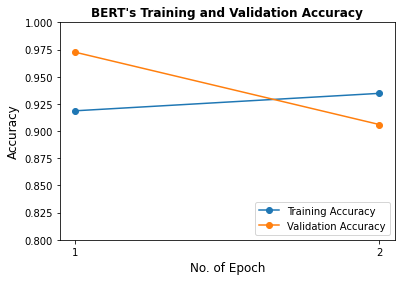

In [33]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]

plt.xticks(np.arange(1, 6, 1))
plt.ylim([0.8, 1])

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'], marker='o')
plt.title("BERT's Training and Validation Accuracy", fontsize=12, fontweight="bold")
plt.xlabel('No. of Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.savefig('gdrive/MyDrive/Colab Notebooks/jigsaw/BERT_v4.png', bbox_inches='tight')
plt.show()

In [34]:
pred = model.predict(valid_data["comment_text"])

In [35]:
pred

array([[0.46606258, 0.05425316, 0.3301078 , 0.02858688, 0.279289  ,
        0.07696095],
       [0.15567723, 0.0023191 , 0.06181267, 0.00561238, 0.07757654,
        0.02193199],
       [0.7144552 , 0.03037221, 0.40351123, 0.01541688, 0.34003422,
        0.19998126],
       ...,
       [0.9415853 , 0.22429332, 0.80789804, 0.06440653, 0.81383467,
        0.18754077],
       [0.9415853 , 0.22429332, 0.80789804, 0.06440653, 0.81383467,
        0.18754077],
       [0.9415853 , 0.22429332, 0.80789804, 0.06440653, 0.81383467,
        0.18754077]], dtype=float32)

In [36]:
result = pd.DataFrame(pred)

In [37]:
result

,0,1,2,3,4,5
0,0.466063,0.054253,0.330108,0.028587,0.279289,0.076961
1,0.155677,0.002319,0.061813,0.005612,0.077577,0.021932
2,0.714455,0.030372,0.403511,0.015417,0.340034,0.199981
3,0.925789,0.096457,0.657644,0.130897,0.718169,0.100484
4,0.662022,0.047259,0.413059,0.028066,0.396053,0.148105
...,...,...,...,...,...,...
60211,0.803461,0.060416,0.436904,0.037950,0.384401,0.084563
60212,0.803461,0.060416,0.436904,0.037950,0.384401,0.084563
60213,0.941585,0.224293,0.807898,0.064407,0.813835,0.187541
60214,0.941585,0.224293,0.807898,0.064407,0.813835,0.187541


In [38]:
result.to_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/BERTv6_result.csv')